In [283]:
import numpy as np
import cv2
import sys
import os
from numpy import interp
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from skimage.transform import resize
from skimage import feature
import pickle
import glob
import imutils

In [218]:
mser_red = cv2.MSER_create(8,200,2000)
mser_blue = cv2.MSER_create(8,200,2000)
mser_green = cv2.MSER_create(8,400,2000)
mser_yellow = cv2.MSER_create(8,400,2000)

In [243]:
#for red
def preprocess_red(img):
    # Convert to grayscale if the image is in color
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype(np.float32)
    resized_img = resize(
      img_gray,
      output_shape=(64,64),
      anti_aliasing=True
  )
    # Extract HOG features
    hog_feature = feature.hog(resized_img, orientations=4, pixels_per_cell=(4, 4),
                cells_per_block=(2, 2), transform_sqrt = False, block_norm="L1", visualize=False, feature_vector=True)


    return hog_feature

In [220]:
# for blue
def preprocess_blue(img):
    # Convert to grayscale if the image is in color
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype(np.float32)
    resized_img = resize(
      img_gray,
      output_shape=(64,64),
      anti_aliasing=True
  )
    # Extract HOG features
    hog_feature = feature.hog(resized_img, orientations=4, pixels_per_cell=(4, 4),
                            cells_per_block=(2, 2), transform_sqrt = False, block_norm="L1", visualize=False, feature_vector=True)

    return hog_feature

In [221]:
#for green
def preprocess_green(img):
  if len(img.shape)>2:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = img.astype(np.float32)

  resized_img = resize(
      img,
      output_shape=(64,64),
      anti_aliasing=True
  )
  hog_feature = feature.hog(
      resized_img,
      orientations=9,
      pixels_per_cell=(8,8),
      cells_per_block=(2,2),
      block_norm="L2",
      feature_vector=True
  )
  return hog_feature

In [222]:
#predict function
def predict_img_red(input_img,classifier):
    normalized_img = preprocess_red(input_img)
    y_pred = classifier.predict([normalized_img])[0]
    y_pred_prob = classifier.predict_proba([normalized_img])[0]
    return y_pred,y_pred_prob
def predict_img_blue(input_img,classifier):
    normalized_img = preprocess_blue(input_img)
    y_pred = classifier.predict([normalized_img])[0]
    y_pred_prob = classifier.predict_proba([normalized_img])[0]
    return y_pred,y_pred_prob

In [305]:
def get_red_contours(img_ihls):
    img_hls = img_ihls.copy()
    img_hls[:,:,1] = cv2.equalizeHist(img_hls[:,:,1])
    img_bgr = cv2.cvtColor(img_hls,cv2.COLOR_HLS2BGR_FULL)

    image_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    lower_red_1 = np.array([130,60,2])
    upper_red_1 = np.array([180,255,255])
    mask_1 = cv2.inRange(image_hsv,lower_red_1,upper_red_1)

    red_mask_ = cv2.bitwise_and(img_bgr,img_bgr, mask = mask_1)

    l_channel = red_mask_[:,:,2]
    s_channel = red_mask_[:,:,1]
    h_channel = red_mask_[:,:,0]

    filtered_r = cv2.medianBlur(l_channel,5)
    filtered_g = cv2.medianBlur(s_channel,5)
    filtered_b = cv2.medianBlur(h_channel,5)

    filtered_red = 10*filtered_r - 0*filtered_b + 0*filtered_g

    regions, _ = mser_red.detectRegions(np.uint8(filtered_red))
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]


    blank= np.zeros_like(red_mask_)

    # hulls_ = []
    # if hulls != []:
    #     for hu in hulls:
    #         x,y,w,h = cv2.boundingRect(hu)
    #         #print(x)
    #         if(x<800):continue
    #         else:
    #             hulls_.append(hu)
    #

    cv2.fillPoly(np.uint8(blank), hulls, (0,0,255))

    kernel_2 = np.ones((1,1),np.uint8)

    opening = cv2.morphologyEx(blank, cv2.MORPH_OPEN, kernel_2)
    resized_eroded = cv2.resize(opening, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)

    _, r_thresh = cv2.threshold(opening[:,:,2], 60, 255, cv2.THRESH_BINARY)

    small_blank = np.zeros((64,64))


    cnts = cv2.findContours(r_thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts , hulls

def get_red_predicted_image(cnts,frame,hulls,red_clf):
    max_cnts = 3
    pred_im = None
    x_ = None
    y_ = None

    prediction_list = []
    countor_list = []
    proba_list = []

    cnts_sorted = sorted(cnts, key=cv2.contourArea, reverse=True)
    # print('in red pred')

    if len(cnts_sorted)>max_cnts:
        cnts_sorted = cnts_sorted[:3]

    for c in cnts_sorted:
        
        x_,y_,w,h = cv2.boundingRect(c)
        if(x_<100):continue
        aspect_ratio = w/h
        """ if aspect_ratio<=0.3 or aspect_ratio>1.2:
            continue """

        cv2.drawContours(frame, hulls, -1, (0, 255, 0), 2)
        mask = np.zeros_like(frame) # Create mask where white is what we want, black otherwise
        cv2.drawContours(mask, [c], -1, (255,255,255), -1) # Draw filled contour in mask
        out = np.zeros_like(frame) # Extract out the object and place into output image
        out[mask == 255] = frame[mask == 255]
        x,y,_ = np.where(mask==255)
        (topx, topy) = (np.min(x), np.min(y))
        (botx, boty) = (np.max(x), np.max(y))
        if np.abs(topx - botx) <= 5 or np.abs(topy - boty)<= 5:
            continue


        out = fin[topx:botx+1, topy:boty+1]
        out_resize = cv2.resize(out, (64,64), interpolation=cv2.INTER_CUBIC)

        pred,pred_proba = predict_img_red(out_resize, red_clf)
        #if pred not in no_sign:
            # pred_im = mapping[str(pred[-1])]
        proba_list.append(max(pred_proba))
        prediction_list.append(pred)
        countor_list.append(c)
    predict = None
    countor = []
    if not proba_list == []:
        _max = max(proba_list)
        if _max > 0.6:
            for i in range(len(proba_list)):
                if proba_list[i] == _max:
                    predict = prediction_list[i]
                    countor = countor_list[i]
    # return pred_im, x_, y_
    return predict,countor

def get_blue_countours(img_ihls):
    img_hls = img_ihls.copy()
    img_hls[:,:,1] = cv2.equalizeHist(img_hls[:,:,1])
    img_bgr = cv2.cvtColor(img_hls,cv2.COLOR_HLS2BGR_FULL)

    image_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    # chỉnh lại lower và upper cho hợp lí (mở rộng ra)
    lower_blue_1 = np.array([94,115,0])
    upper_blue_1 = np.array([126,255,200])
    mask = cv2.inRange(image_hsv,lower_blue_1,upper_blue_1)
    #mask
    blue_mask_ = cv2.bitwise_and(img_bgr,img_bgr, mask = mask)

    l_channel = blue_mask_[:,:,2]
    s_channel = blue_mask_[:,:,1]
    h_channel = blue_mask_[:,:,0]

    filtered_r = cv2.medianBlur(l_channel,5)
    filtered_g = cv2.medianBlur(s_channel,3)
    filtered_b = cv2.medianBlur(h_channel,3)
    #filter màu xanh
    filtered_red = -0*filtered_r + 10*filtered_b - 0*filtered_g
    regions, _ = mser_blue.detectRegions(np.uint8(filtered_red))

    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    #khoanh vùng
    blank= np.zeros_like(blue_mask_)

    cv2.fillPoly(np.uint8(blank), hulls, (0,0,255))

    kernel_2 = np.ones((1,1),np.uint8)
    #mở rộng vùng
    opening = cv2.morphologyEx(blank, cv2.MORPH_OPEN, kernel_2)

    resized_eroded = cv2.resize(opening, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    _, r_thresh = cv2.threshold(opening[:,:,2],30, 255, cv2.THRESH_BINARY)

    small_blank = np.zeros((64,64))

    cnts = cv2.findContours(r_thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return cnts,hulls

def get_blue_predicted_image(cnts,frame,hulls,blue_clf):
    max_cnts = 3
    # x_ ,y_ = 0
    pred_im = None
    x_  = None
    y_ = None

    prediction_list = []
    countor_list = []
    proba_list = []

    # 
    print('in blue pred')
    cnts_sorted = sorted(cnts, key=cv2.contourArea, reverse=True)
    if len(cnts_sorted)>max_cnts:
        cnts_sorted = cnts_sorted[:3]

    for c in cnts_sorted:
        # print('in sorted333')
        x_ , y_, w, h = cv2.boundingRect(c)

        #print(x_,y_)

        if (x_<100):
            #print('1')
            continue
        if h<20:
            # print('2')
            continue
        if h>20 and h<40:
            #print('3')
            h = h+20
            w = 0.7*h

        aspect_ratio = w/h

        """ if aspect_ratio<=0.3 or aspect_ratio>1.2:
            # 
            print('4')
            continue """
        cv2.drawContours(frame, hulls, -1, (0, 255, 0), 2)
        mask = np.zeros_like(frame) # Create mask where white is what we want, black otherwise
        cv2.drawContours(mask, [c], -1, (255,255,255), -1) # Draw filled contour in mask
        out = np.zeros_like(frame) # Extract out the object and place into output image
        out[mask == 255] = frame[mask == 255]
        x,y,_ = np.where(mask==255)
        (topx, topy) = (np.min(x), np.min(y))
        (botx, boty) = (np.max(x), np.max(y))
        #check countor is too mall
        if np.abs(topx - botx) <= 5 or np.abs(topy - boty)<= 5:
            # 
            print('5')
            continue

        out = fin[topx:botx+1, topy:boty+1]
        out_resize = cv2.resize(out, (64,64), interpolation=cv2.INTER_CUBIC)
        pred, pred_proba = predict_img_blue(out_resize, blue_clf)
        print(pred_proba)
        #if pred not in no_sign:
            # pred_im = mapping[str(pred[-1])]
            # prediction_list.append(pred[0])
            # countor_list.append(c)
        #Đây là phần chung với lệnh if phía trên sẽ tìm hiểu sau
        proba_list.append(max(pred_proba))
        prediction_list.append(pred)
        countor_list.append(c)
    predict = None
    countor = []
    if not proba_list == []:
        _max = max(proba_list)
        for i in range(len(proba_list)):
            if proba_list[i] == _max:
                predict = prediction_list[i]
                countor = countor_list[i]
    # return pred_im, x_, y_
    return predict,countor


In [288]:
#load model
with open("red.pkl", "rb") as f:
    red_clf = pickle.load(f)
with open("blue.pkl", "rb") as f:
    blue_clf = pickle.load(f)

#label
red_labels = ["forbit","stop"]
blue_labels = ["cross way","parking","roundabout","traight"]

In [289]:
#test with image
def detect(image):
    #image = np.uint8(cv2.imread("53.png"))
    frame = image.copy()
    fin = image.copy()
    img_ihls = cv2.cvtColor(frame,cv2.COLOR_BGR2HLS_FULL)
    red_cnts, red_hulls = get_red_contours(img_ihls)
    #red detect
    if not red_cnts == []:
            red_pred, red_cnt = get_red_predicted_image(red_cnts, frame, red_hulls, red_clf)

            if red_pred is not None:
                #for i in range(len(red_cnts)):
                    x,y,w,h = cv2.boundingRect(red_cnt)
                    cv2.rectangle(fin, (x,y), (int(x+w) , int(y+h)) , (0,255,0),2)
                    new_x = x - 64
                    new_y = y + 64
                    label = red_labels[red_pred]
                    cv2.putText(fin, label, (new_x, new_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    #blue detect
    blue_cnts, blue_hulls = get_blue_countours(img_ihls)
    if not blue_cnts == []:
        # blue_pred, blue_x, blue_y = get_blue_predicted_image(blue_cnts, frame, blue_hulls, blue_classifier)
        blue_pred, blue_cnt = get_blue_predicted_image(blue_cnts, frame, blue_hulls, blue_clf)
        # cv2.imshow('blue pred',blue_pred)
        # cv2.waitKey(0)

        if blue_pred is not None:
            #for i in range(len(blue_cnts)):
            x,y,w,h = cv2.boundingRect(blue_cnt)
            cv2.rectangle(fin, (x,y), (int(x+w) , int(y+h)) , (0,255,0),2)
            new_x_ = x - 64
            new_y_ = y + 64
            label = blue_labels[blue_pred]
            cv2.putText(fin, label, (new_x_, new_y_), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return fin

in blue pred
[0.26389363 0.30040304 0.43217043 0.0035329 ]


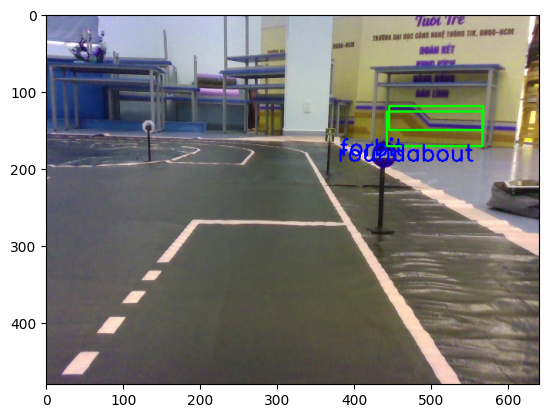

In [308]:
def getData(path):
    img_lst = []
    sign_items = os.listdir(path)
    # Filter out only the files (not directories)
    img_dir = [item for item in sign_items if os.path.isfile(os.path.join(path, item))]
    for img_path in img_dir:
        img_p = os.path.join(path,img_path)
        img = cv2.imread(img_p)
        img_lst.append(img)
    return img_lst

img_lst = getData("Sample")
#for img in img_lst:
res = detect(img_lst[0])
plt.imshow(res)
plt.show() 